# Import Library

In [129]:
import tensorflow
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM,GRU, Bidirectional,LayerNormalization,BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
import optuna
from tensorflow_addons.layers import WeightNormalization
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
os.getcwd()

'C:\\Users\\USER\\Desktop\\Kev\\碩一\\人工智慧\\HW4'

# Load Data

In [130]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(r'./data/train.csv')
print('view the data shape', train_df.shape)
train_df.head()

view the data shape (19992, 46)


,id,cycle,setting1,setting2,setting3,setting4,setting5,setting6,setting7,setting8,...,s25,s26,s27,s28,s29,s30,s31,s32,s33,RUL
0,1,1,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0007,...,392,2388,100,39.06,23.4190,17.417395,-5.424438,-11.046572,33.975011,191
1,1,2,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0019,...,392,2388,100,39.00,23.4236,2.692229,6.492347,-1.090195,1.763264,190
2,1,3,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0043,...,390,2388,100,38.95,23.3442,17.608505,11.462310,-35.453907,3.903670,189
3,1,4,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0007,...,392,2388,100,38.88,23.3739,2.885575,1.767567,1.996286,-3.450681,188
4,1,5,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0019,...,393,2388,100,38.90,23.4044,11.038508,8.525787,-0.011158,-1.185085,187


In [131]:
# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(r'./data/test.csv')
print('viwe the data shape', test_df.shape)
test_df.head()

viwe the data shape (12739, 45)


,id,cycle,setting1,setting2,setting3,setting4,setting5,setting6,setting7,setting8,...,s24,s25,s26,s27,s28,s29,s30,s31,s32,s33
0,1,1,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0023,...,0.03,392,2388,100,38.86,23.3735,5.386944,23.428504,-9.560946,-4.663842
1,1,2,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0027,...,0.03,393,2388,100,39.02,23.3916,-13.673782,21.433667,18.019028,16.455364
2,1,3,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0003,...,0.03,393,2388,100,39.08,23.4166,12.873506,2.818419,8.161708,14.703674
3,1,4,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0042,...,0.03,391,2388,100,39.00,23.3737,-40.262316,-5.958041,-1.516838,11.854112
4,1,5,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0014,...,0.03,390,2388,100,38.99,23.4130,-11.969663,-3.499189,-16.507371,-20.250312


# EDA

## Train Output

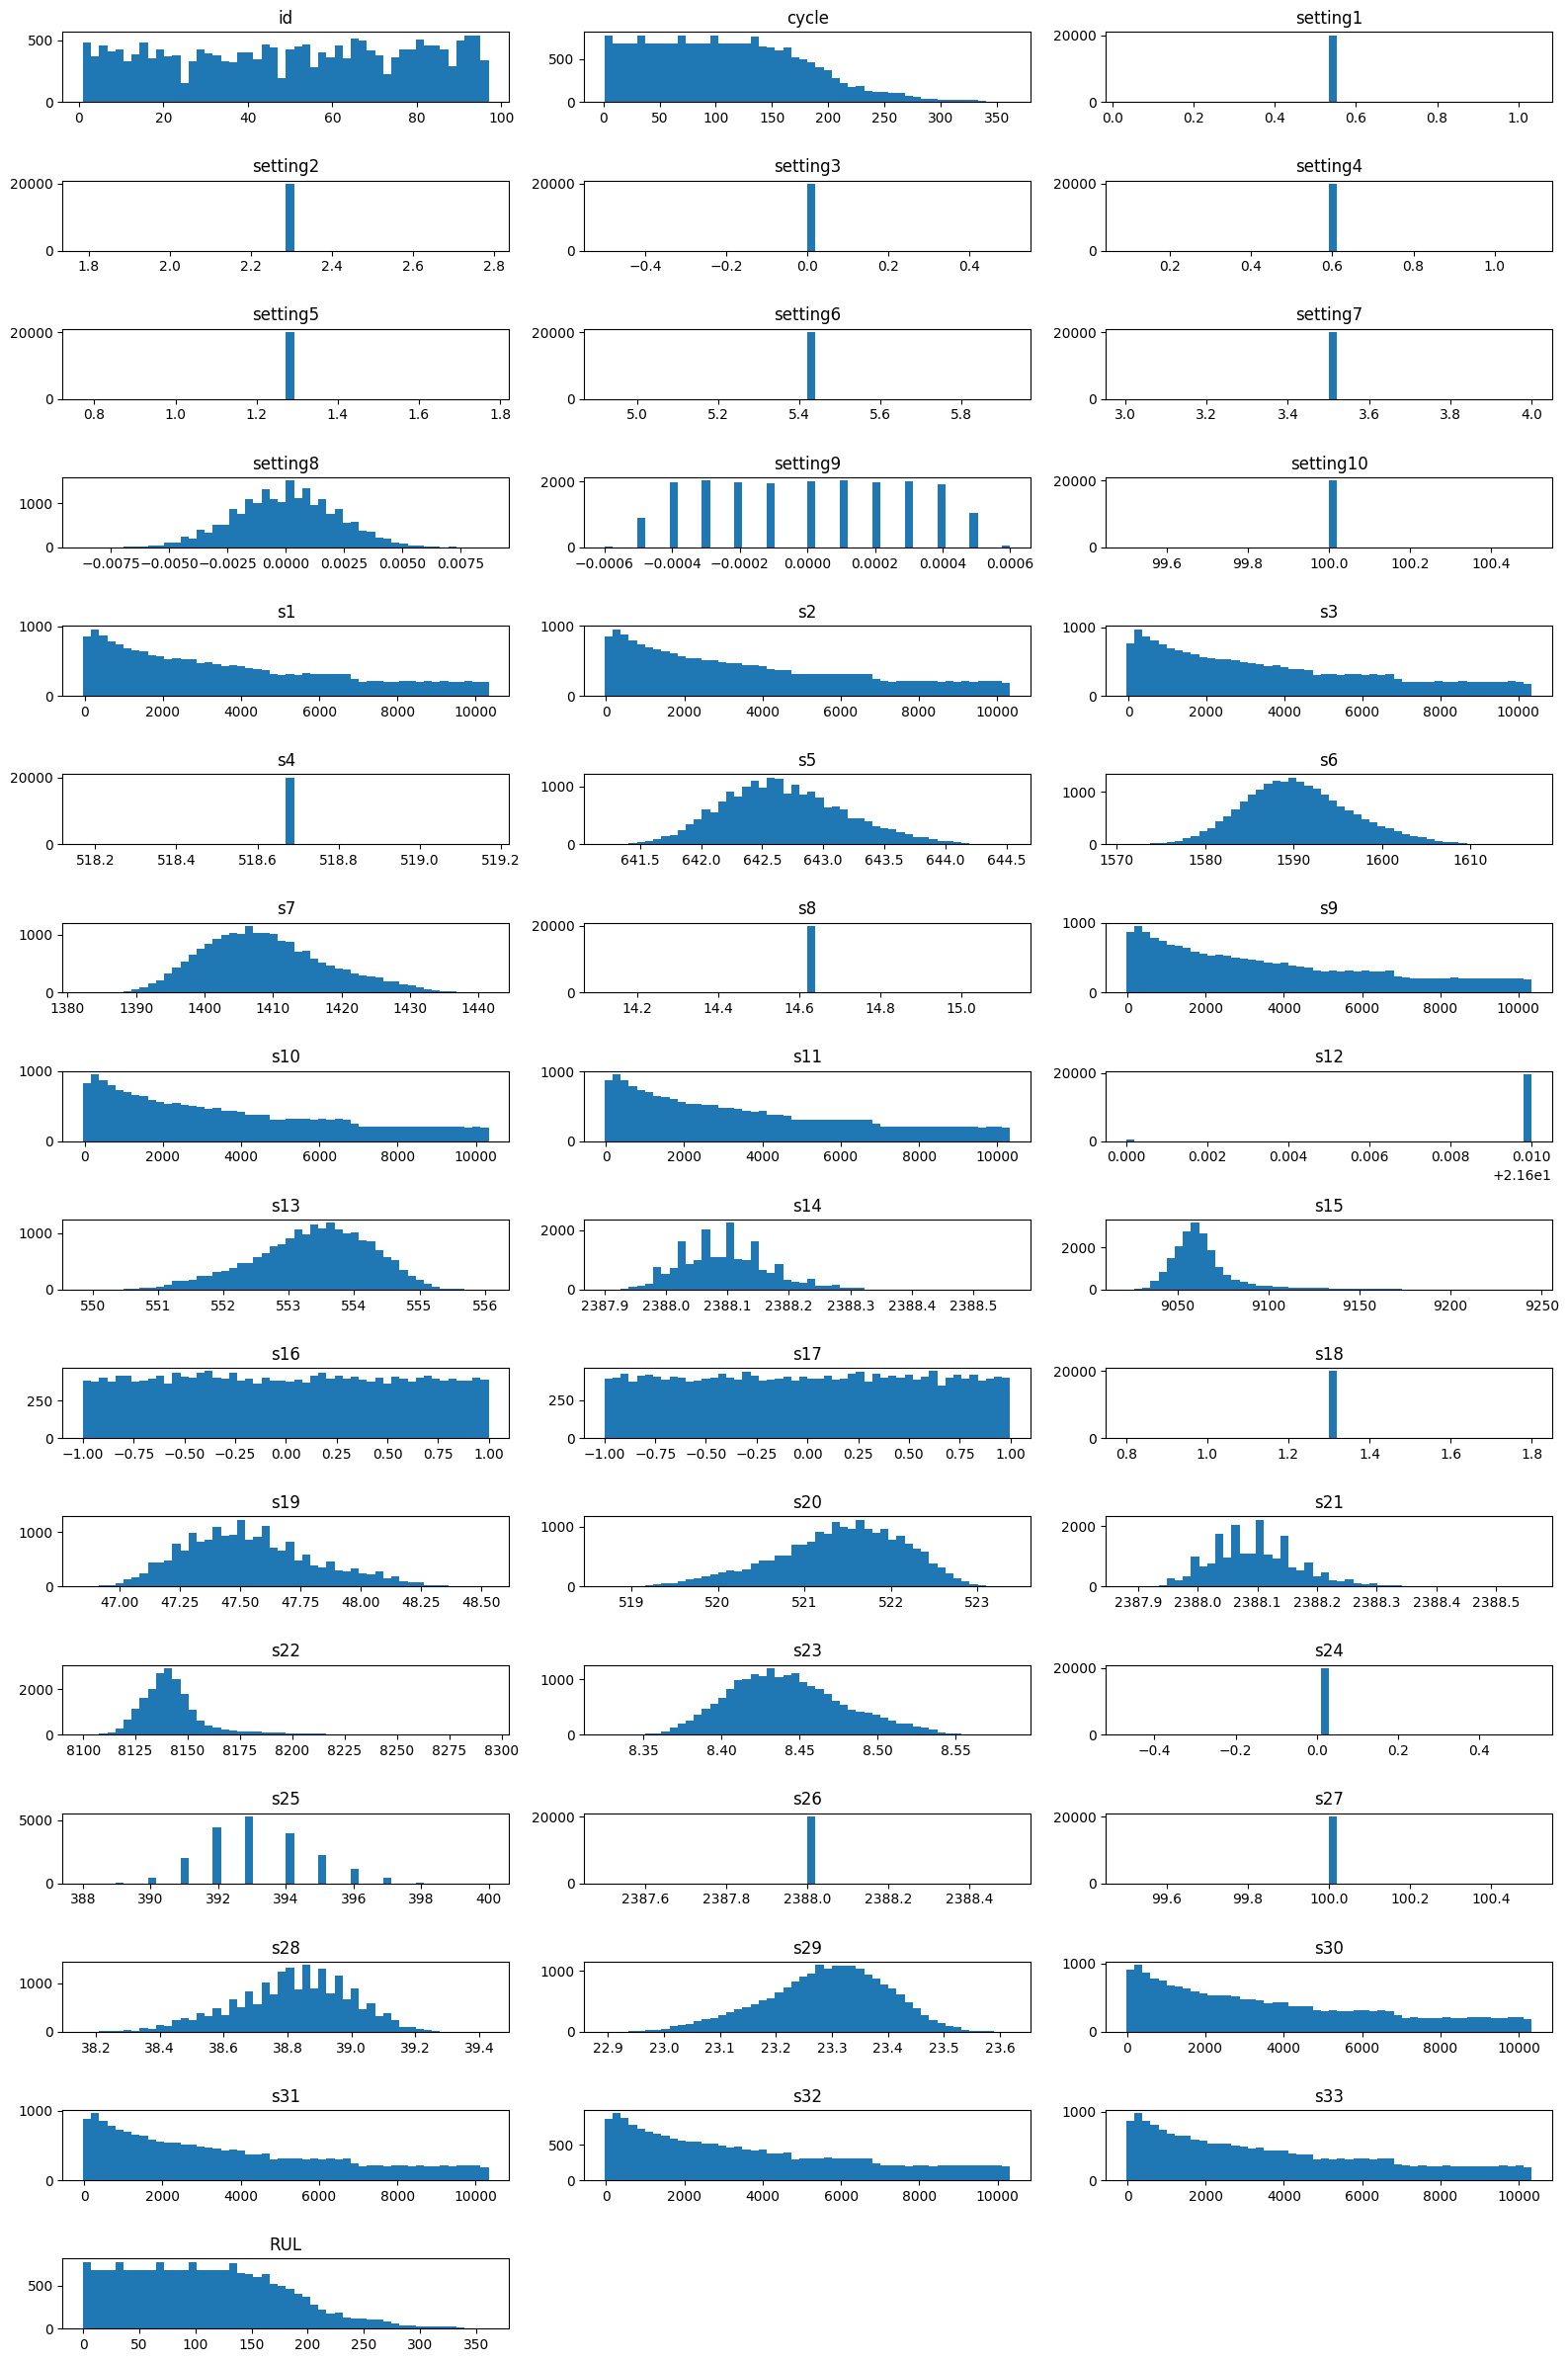

In [132]:
plt.figure(figsize=(16,24))

for i_index, i in enumerate(train_df.columns):
    plt.subplot(16,3,i_index+1)
    plt.title(i)
    plt.hist(train_df[i], bins=50)
    
plt.tight_layout()
plt.show()

In [133]:
#刪除重複欄位後檢視其欄位間關聯性
check_corr = train_df.drop(['cycle','setting1', 'setting2', 'setting3', 'setting4',
               'setting5', 'setting6', 'setting7','setting10','s4','s8',
               's18','s24','s26','s27'],axis=1)

<AxesSubplot: >

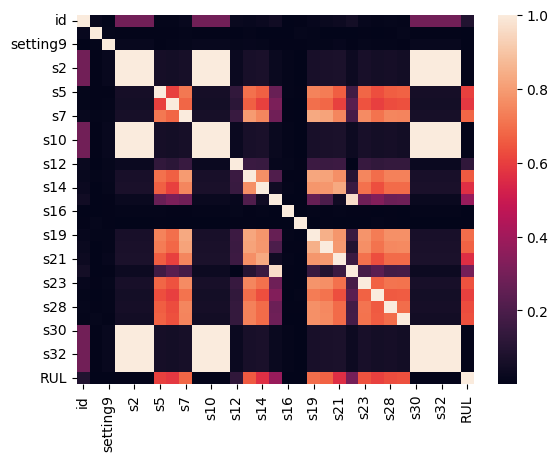

In [134]:
sns.heatmap(check_corr.corr().abs())

In [135]:
corr_matrix = check_corr.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop_train = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop_train)

['s2', 's3', 's9', 's10', 's11', 's22', 's30', 's31', 's32', 's33']


C:\Users\USER\AppData\Local\Temp\ipykernel_27296\1441464459.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


## Test Output

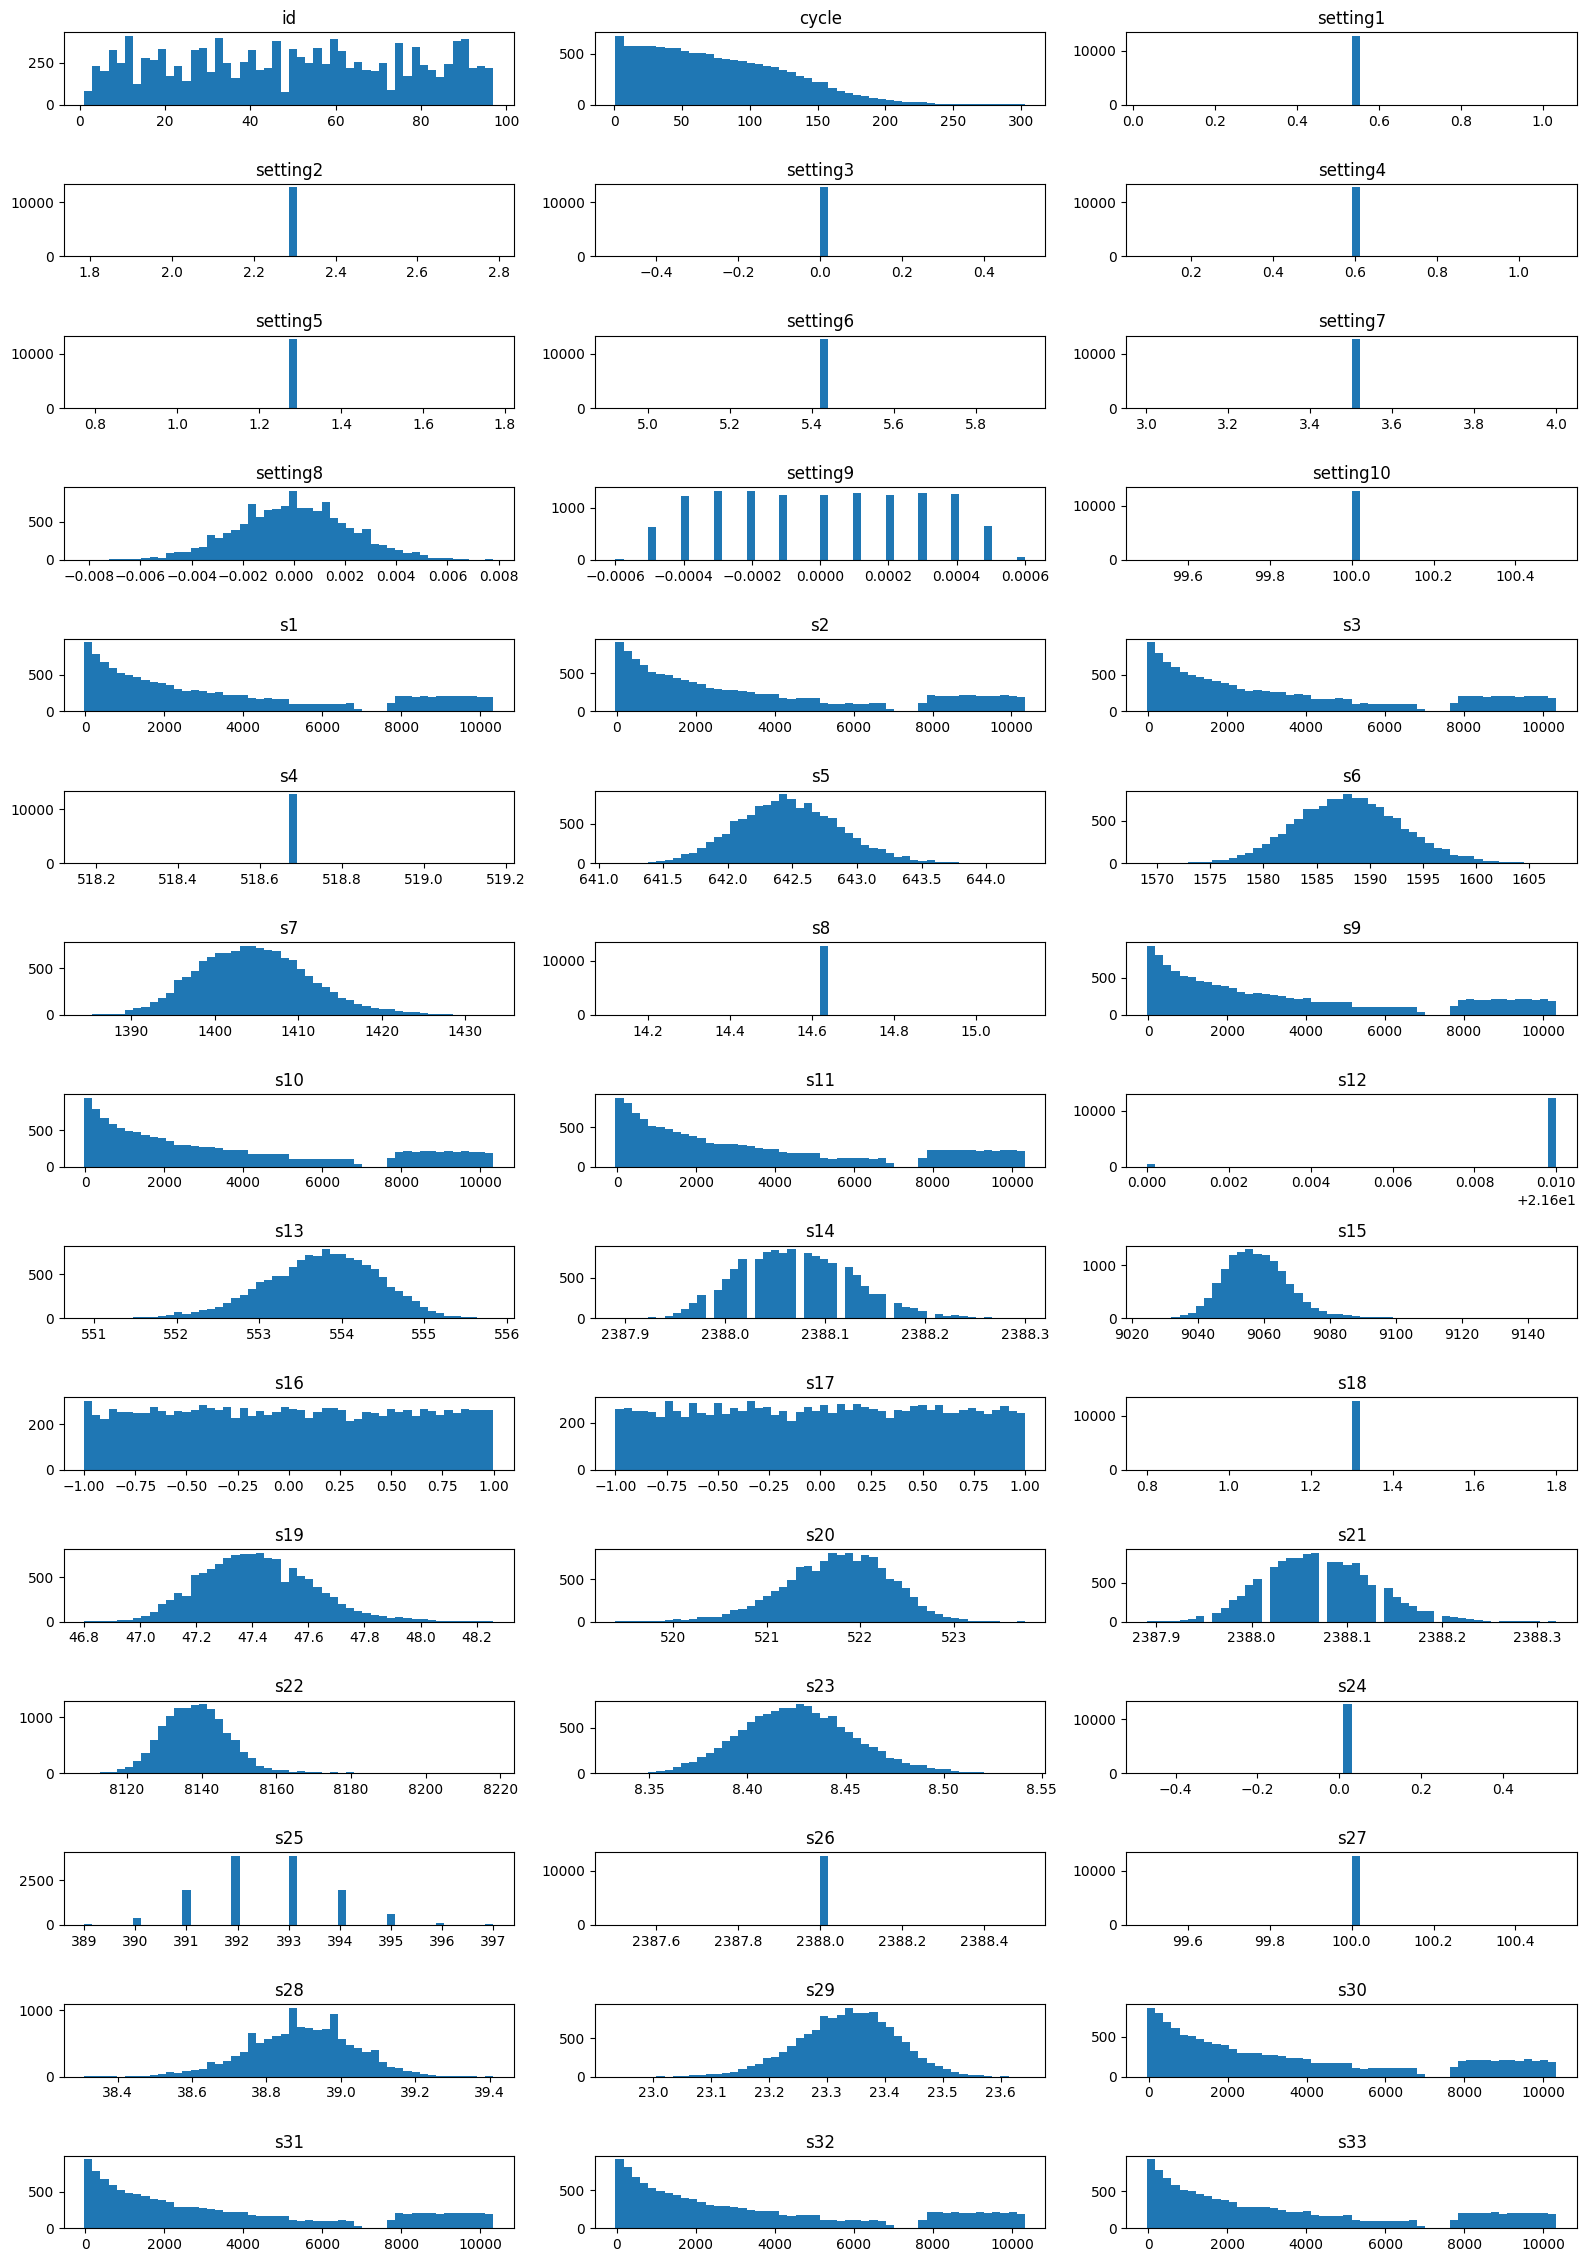

In [136]:
plt.figure(figsize=(16,24))

for i_index, i in enumerate(test_df.columns):
    plt.subplot(16,3,i_index+1)
    plt.title(i)
    plt.hist(test_df[i], bins=50)
    
plt.tight_layout()
plt.show()

In [137]:
#刪除重複欄位後檢視其欄位間關聯性
check_corr = test_df.drop(['cycle','setting1', 'setting2', 'setting3', 'setting4',
               'setting5', 'setting6', 'setting7','setting10','s4','s8',
               's18','s24','s26','s27'],axis=1)

<AxesSubplot: >

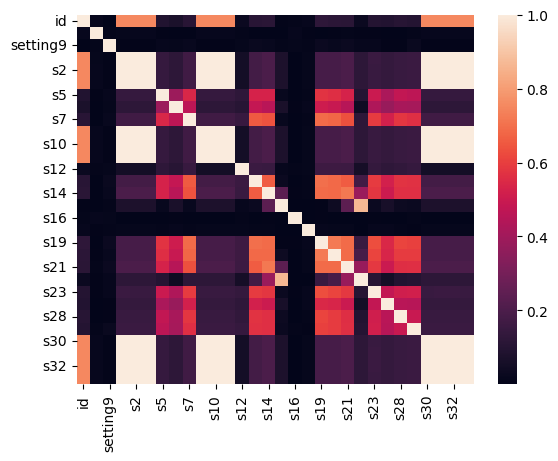

In [138]:
sns.heatmap(check_corr.corr().abs())

In [139]:
corr_matrix = check_corr.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop_test = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop_test)

['s2', 's3', 's9', 's10', 's11', 's30', 's31', 's32', 's33']


C:\Users\USER\AppData\Local\Temp\ipykernel_27296\3988599239.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


## 比較兩者共線性高的欄位

In [140]:
print(to_drop_train)
print(to_drop_test)

['s2', 's3', 's9', 's10', 's11', 's22', 's30', 's31', 's32', 's33']
['s2', 's3', 's9', 's10', 's11', 's30', 's31', 's32', 's33']


S22 不一樣!!! 後續作為實驗因子

# 前處理

## 分布靠近常態 -> 標準化；否則 -> MaxMin

In [141]:
MaxMin_list = ['setting9',
 's1',
 's2',
 's3',
 's9',
 's10',
 's11',
 's12',
 's16',
 's17',
 's30',
 's31',
 's32',
 's33']
Standard_list = ['setting8',
 's5',
 's6',
 's7',
 's13',
 's14',
 's15',
 's19',
 's20',
 's21',
 's22',
 's23',
 's25',
 's28',
 's29']

In [142]:
# MinMax Scaler
MaxMin_trainsform = MinMaxScaler()
train_df_MM = train_df.loc[:,MaxMin_list]
train_df_MM = pd.DataFrame(MaxMin_trainsform.fit_transform(train_df_MM),columns=train_df_MM.columns)
test_df_MM = test_df.loc[:,MaxMin_list]
test_df_MM = pd.DataFrame(MaxMin_trainsform.transform(test_df_MM),columns=test_df_MM.columns)

# Sd Scaler
sd_transform = StandardScaler()
train_df_sd = train_df.loc[:,Standard_list]
train_df_sd =  pd.DataFrame(sd_transform.fit_transform(train_df_sd),columns=train_df_sd.columns)
test_df_sd = test_df.loc[:,Standard_list]
test_df_sd = pd.DataFrame(sd_transform.transform(test_df_sd),columns=test_df_sd.columns)

# Remain Value
train_df_remain = train_df.loc[:,['id','cycle','RUL']]                           
test_df_remain = test_df.loc[:,['id','cycle']]

train_df = pd.concat([train_df_remain,train_df_sd,train_df_MM],axis=1)
test_df = pd.concat([test_df_remain,test_df_sd,test_df_MM],axis=1)

In [143]:
# del train_df_MM,train_df_remain,train_df_sd,test_df_MM,test_df_remain,test_df_sd

## 刪掉共線性高的欄位

In [144]:
train_df.drop(to_drop_test,axis=1,inplace=True)
test_df.drop(to_drop_test,axis=1,inplace=True)

In [145]:
train_df

,id,cycle,RUL,setting8,s5,s6,s7,s13,s14,s15,...,s22,s23,s25,s28,s29,setting9,s1,s12,s16,s17
0,1,1,191,-0.318363,-1.718210,-0.131492,-0.924896,1.119167,-0.516101,-0.858959,...,-0.263098,-0.602245,-0.778356,1.346990,1.193360,0.166667,0.003117,1.0,0.016074,0.111808
1,1,2,190,0.869244,-1.059332,0.214092,-0.642970,0.430972,-0.796348,-0.955099,...,-0.636921,-0.274388,-0.778356,1.015099,1.235829,0.250000,0.001638,1.0,0.095109,0.278304
2,1,3,189,-1.962741,-0.660012,-0.410241,-0.525317,1.006348,-0.235853,-0.552849,...,-0.545693,-0.647559,-2.068860,0.738523,0.502791,0.750000,0.003757,1.0,0.884364,0.924662
3,1,4,188,0.321118,-0.660012,-1.257900,-0.783933,1.220704,0.184519,-0.709759,...,-0.514236,-1.969650,-0.778356,0.351317,0.776988,0.500000,0.004501,1.0,0.390404,0.489292
4,1,5,187,-0.866489,-0.620080,-1.248120,-0.301108,0.713019,-0.516101,-0.452627,...,-0.515808,-0.338360,-0.133104,0.461947,1.058570,0.333333,0.007949,1.0,0.144314,0.270271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,97,181,4,-0.683780,2.075332,1.611100,2.119676,-2.570013,2.426501,-0.464871,...,-1.053211,1.236954,1.802652,-1.750659,-2.282566,0.416667,0.024584,1.0,0.917664,0.685822
19988,97,182,3,-1.231906,1.676011,2.416376,2.373853,-1.983354,2.286377,-0.082575,...,-0.663135,1.874010,-0.133104,-2.359126,-2.975905,0.250000,0.025601,1.0,0.156845,0.623637
19989,97,183,2,-1.414615,2.554516,2.680455,2.105247,-2.829497,3.127120,-0.423150,...,-0.877572,2.540387,1.157400,-1.363453,-1.345497,0.250000,0.022968,1.0,0.765491,0.390597
19990,97,184,1,-0.455394,2.834040,1.580128,3.064237,-2.096173,2.706749,-0.196856,...,-0.942584,3.121467,1.157400,-2.027235,-2.233635,0.416667,0.022765,1.0,0.734165,0.093201


In [146]:
test_df

,id,cycle,setting8,s5,s6,s7,s13,s14,s15,s19,...,s22,s23,s25,s28,s29,setting9,s1,s12,s16,s17
0,1,1,1.051953,0.677711,-0.850372,-1.190172,0.600200,-0.796348,-0.678468,-1.274441,...,-0.948352,-0.983413,-0.778356,0.240687,0.773295,0.750000,0.002687,1.0,0.512253,0.126977
1,1,2,-1.231906,-1.937836,-0.335256,-1.499846,1.671980,-1.216720,-0.485732,-0.153136,...,-0.210669,-1.647124,-0.133104,1.125730,0.940398,0.250000,0.005316,1.0,0.516322,0.278966
2,1,3,0.138409,-0.440386,-0.581403,-0.842760,0.837120,-0.656224,-0.370545,-0.153136,...,-0.709798,0.053469,-0.133104,1.457621,1.171203,0.583333,0.005346,1.0,0.259101,0.402603
3,1,4,1.919819,-0.480318,-1.041095,-0.278909,0.791992,-0.936472,-0.899773,-0.975426,...,-0.562995,-1.343256,-1.423608,1.015099,0.775141,0.500000,0.002749,1.0,0.302456,0.483654
4,1,5,0.640858,-0.340556,-0.540650,-0.778383,0.893529,-1.216720,-0.933332,-0.863296,...,-0.739158,-1.039388,-2.068860,0.959784,1.137967,0.500000,0.005417,1.0,0.114279,0.077009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12734,97,93,-0.683780,-0.879638,-0.671059,-0.829441,1.412497,-1.076596,-0.124750,-1.573455,...,0.890350,-0.503621,-0.778356,1.457621,1.805456,0.750000,0.750112,1.0,0.057710,0.340107
12735,97,94,-0.729457,-0.400454,-0.801468,-1.263428,1.581725,-1.076596,0.034880,-0.975426,...,0.457283,-1.393901,-1.423608,0.461947,0.926550,0.166667,0.751682,1.0,0.926848,0.100303
12736,97,95,-1.277583,0.238459,-1.446994,-1.308936,0.351998,-1.496968,0.339628,-1.423948,...,0.239176,-1.652455,-1.423608,1.402305,-0.038216,0.750000,0.750691,1.0,0.147628,0.288321
12737,97,96,-0.638103,-0.699944,-1.160093,-0.622991,0.758147,-1.637092,0.254371,-1.461325,...,0.361337,-1.063378,-2.068860,0.849154,1.498023,0.333333,0.749794,1.0,0.401516,0.732482


## 將資料轉為序列型

In [147]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [148]:
train_df['id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97], dtype=int64)

In [160]:
# generate features
# pick the feature columns 
# sensor_cols = ['s' + str(i) for i in range(1,34)]
# sequence_cols = ['setting'+ str(i) for i in range(1,11)]
# sequence_cols.extend(sensor_cols)
sequence_cols = list(test_df.columns)
sequence_cols.remove('id')
sequence_cols.remove('cycle')
sequence_length = 30

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

print(seq_array.shape)
print(label_array.shape)

(17082, 30, 20)
(17082, 1)


In [161]:
seq_array

array([[[-0.31836256, -1.7182103 , -0.13149169, ...,  1.        ,
          0.01607386,  0.11180821],
        [ 0.86924416, -1.059332  ,  0.21409243, ...,  1.        ,
          0.09510949,  0.27830428],
        [-1.962741  , -0.6600118 , -0.41024116, ...,  1.        ,
          0.8843641 ,  0.92466235],
        ...,
        [-1.0948746 , -0.6600118 , -1.2497498 , ...,  1.        ,
          0.30971238,  0.35200685],
        [ 0.54950386, -1.5385163 , -0.9253571 , ...,  1.        ,
          0.0885433 ,  0.2424514 ],
        [-1.0035203 , -0.959502  ,  0.49121177, ...,  1.        ,
          0.8264259 ,  0.5733159 ]],

       [[ 0.86924416, -1.059332  ,  0.21409243, ...,  1.        ,
          0.09510949,  0.27830428],
        [-1.962741  , -0.6600118 , -0.41024116, ...,  1.        ,
          0.8843641 ,  0.92466235],
        [ 0.321118  , -0.6600118 , -1.2579004 , ...,  1.        ,
          0.39040384,  0.4892917 ],
        ...,
        [ 0.54950386, -1.5385163 , -0.9253571 , ...,  

# Feature Selection

In [153]:
import xgboost as xgb

In [154]:
ALL_data = []

for id_index in train_df['id'].unique():
    df_tmp = train_df[train_df['id']==id_index]
    X = df_tmp.drop(['RUL','cycle'],axis=1)
    y = df_tmp['RUL']
    model_xgb = xgb.XGBRegressor()
    model_xgb.fit(X,y)
    feature_important = model_xgb.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    ALL_data.append(data)

In [155]:
Importance_xgb = pd.DataFrame([0 for x in range(len(train_df.columns))],index=train_df.columns)
Importance_xgb.rename({0:'Importance'},axis=1,inplace=True)

In [156]:
for df in ALL_data:
    for score,feature in zip(df['score'],df.index):
        Importance_xgb.loc[feature,:] += score
Importance_xgb.sort_values(by='Importance',ascending=False)

,Importance
setting8,32169
s5,18818
s6,15871
s7,13390
s13,11682
s15,11498
s1,10919
s17,10255
s16,10028
s23,9695


In [163]:
Feature_list = sequence_cols
Feature_list

['setting8',
 's5',
 's6',
 's7',
 's13',
 's14',
 's15',
 's19',
 's20',
 's21',
 's22',
 's23',
 's25',
 's28',
 's29',
 'setting9',
 's1',
 's12',
 's16',
 's17']

# Split Train and Validation 

## 用篩選出之特徵重新建構資料

In [164]:
sequence_length = 30
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, Feature_list)) 
           for id in train_df['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32) 

## 使用機台別進行分層抽樣

In [166]:
import random
from tqdm import tqdm
random.seed(42)

test = list(train_df.groupby(['id'])['cycle'].max()-sequence_length)
test_output = []
for i in range(len(test)):
    if i==0:
        test_output.append(test[i])
    else:
        test_output.append(test[i]+test_output[i-1])

In [167]:
output_seq =  [0] +test_output
id_list_seq = []
id_list_label = []
for ele_index in range(len(output_seq)-1):
    start_index = output_seq[ele_index]
    end_index = output_seq[ele_index+1]
    tmp_seq = seq_array[start_index:end_index]
    tmp_label = label_array[start_index:end_index]
    
    id_list_seq.append(tmp_seq)
    id_list_label.append(tmp_label)

In [168]:
ratio = 0.1
sample_size = int(np.floor(97*ratio))

for i_index,i in enumerate(random.sample(range(len(id_list_seq)),97)):
    if i_index==0:
        valid_array = id_list_seq[i]
        valid_label = id_list_label[i]        

    elif i_index < sample_size:          
        valid_array = np.concatenate([valid_array,id_list_seq[i]])
        valid_label = np.concatenate([valid_label,id_list_label[i]])

    elif i_index == sample_size:
        train_array = id_list_seq[i]          
        train_label = id_list_label[i]   

    elif i_index > sample_size:
        train_array = np.concatenate([train_array,id_list_seq[i]])                
        train_label = np.concatenate([train_label,id_list_label[i]])

## 使用機台別的時間窗格進行分層抽樣

In [ ]:
# import random
# from tqdm import tqdm
# ratio = 0.05
# SIZE = seq_array.shape[0]
# window_size = seq_array.shape[1]
# feature_size = seq_array.shape[2]

# test = list(train_df.groupby(['id'])['cycle'].max()-sequence_length)
# test_output = []
# for i in range(len(test)):
#     if i==0:
#         test_output.append(test[i])
#     else:
#         test_output.append(test[i]+test_output[i-1])

In [ ]:
# import random
# from tqdm import tqdm
# ratio = 0.1
# SIZE = seq_array.shape[0]
# window_size = seq_array.shape[1]
# feature_size = seq_array.shape[2]

# test = list(train_df.groupby(['id'])['cycle'].max()-sequence_length)
# test_output = []
# for i in range(len(test)):
#     if i==0:
#         test_output.append(test[i])
#     else:
#         test_output.append(test[i]+test_output[i-1])
        
# for id in tqdm(range(97)):
#     random.seed(id+42+42)
#     if id==0:
#         start_index = 0
#         end_index = test_output[id]
        
#         random_list = random.sample(range(start_index,end_index), end_index-start_index)
#         sample_size = int((end_index-start_index+1)*ratio)
        
#         for i_index,i in enumerate(random_list):
#             if i_index==0:
#                 valid_array = seq_array[i:i+1]
#                 valid_label = label_array[i:i+1]                

#             elif i_index < sample_size:          
#                 valid_array = np.concatenate([valid_array,seq_array[i:i+1]])
#                 valid_label = np.concatenate([valid_label,label_array[i:i+1]])
                
#             elif i_index == sample_size:
#                 train_array = seq_array[i:i+1]                
#                 train_label = label_array[i:i+1] 
                
#             elif i_index > sample_size:
#                 train_array = np.concatenate([train_array,seq_array[i:i+1]])                
#                 train_label = np.concatenate([train_label,label_array[i:i+1]])
        
#     else:
#         start_index = test_output[id-1]
#         end_index = test_output[id]
        
#         random_list = random.sample(range(start_index,end_index), end_index-start_index)
#         sample_size = int((end_index-start_index+1)*ratio)
        
#         for i_index,i in enumerate(random_list):             
#             if i_index < sample_size:          
#                 valid_array = np.concatenate([valid_array,seq_array[i:i+1]])
#                 valid_label = np.concatenate([valid_label,label_array[i:i+1]]) 
                
#             elif i_index >= sample_size:
#                 train_array = np.concatenate([train_array,seq_array[i:i+1]])                
#                 train_label = np.concatenate([train_label,label_array[i:i+1]])

In [170]:
print(seq_array.shape)
print(label_array.shape)
print(train_array.shape)
print(train_label.shape)
print(valid_array.shape)
print(valid_label.shape)

(17082, 30, 20)
(17082, 1)
(15482, 30, 20)
(15482, 1)
(1600, 30, 20)
(1600, 1)


# Optuna

## Define Objective function

In [171]:
class attention(tensorflow.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [172]:
def objective(trial):
    
    #OPTUNA
    n_layers = trial.suggest_int('n_layers', 0,5,step=1)
    num_hidden = trial.suggest_int(f'num_hidden', 40, 200, step=10)
    num_hidden_dense = trial.suggest_int(f'num_hidden_dense', 40, 200, step=10)
    num_dropout = trial.suggest_float(f'n_dropout',0.1, 0.5, step=0.05)
    num_lr = trial.suggest_float(f'n_lr',1e-5, 1e-1, log=True)
    num_batch = trial.suggest_int('num_batch', 20, 400,step=20)
    sequence_length = trial.suggest_int('sequence_length', 10, 30,step=2)
    
    ### 生成資料集
    # generator for the sequences
    seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, Feature_list)) 
               for id in train_df['id'].unique())
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
    # generate labels
    label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
                 for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)    
    
    ###　訓練模型
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]
    model = Sequential()

    model.add(Bidirectional(LSTM(
        input_shape=(sequence_length, nb_features),
        units = num_hidden,
        return_sequences=True)))
    # add dropout layer
    model.add(Dropout(num_dropout))
    model.add(BatchNormalization())     

    
    for i in range(n_layers):
        # add LSTM layer
        model.add(Bidirectional(LSTM(
            input_shape=(sequence_length, nb_features),
            units = num_hidden,
            return_sequences=True)))
        # add dropout layer
        model.add(Dropout(num_dropout))
        model.add(BatchNormalization())            

    model.add(attention())
    model.add(BatchNormalization())
    
    model.add(Dense(num_hidden_dense, trainable=True, activation = 'relu'))
    model.add(Dropout(num_dropout))    
    model.add(BatchNormalization())
    
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mae', optimizer= Adam(learning_rate=num_lr),metrics=['mae'])
    
    # fit the network
    model_checkpoint_callback_stop = callbacks.EarlyStopping(monitor='val_mae',patience=20,mode='min')
    history = model.fit(seq_array, label_array, epochs=150, 
                        batch_size=num_batch, validation_split=0.1, 
                        callbacks=[model_checkpoint_callback_stop],verbose=2,)
    
    return min(history.history['val_mae'])

## Run Optimization with TPESampler

In [173]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Model with best hyperparameters

In [188]:
### 生成資料集
# generator for the sequences
# n_layers = 2
num_hidden = 120
num_hidden_dense = 120
num_dropout = 0.5
num_lr = 0.001
num_batch = 500
sequence_length = 30

# seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, Feature_list)) 
#            for id in train_df['id'].unique())
# seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# # generate labels
# label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
#              for id in train_df['id'].unique()]
# label_array = np.concatenate(label_gen).astype(np.float32)    

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

###　訓練模型
model = Sequential()
model.add(BatchNormalization(input_shape=(sequence_length, nb_features),))  

# add LSTM layer
model.add(Bidirectional(LSTM(
    units = num_hidden,
    return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())            
# add LSTM layer
model.add(Bidirectional(LSTM(
    units = num_hidden,
    return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 

model.add(Bidirectional(LSTM(
    units = num_hidden,
    return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 


model.add(attention())
model.add(BatchNormalization())

# model.add(Dense(120, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mae', optimizer= Adam(learning_rate=num_lr),metrics=['mae'])

# fit the network
# callbacks
checkpoint_filepath = './log_model_weight/'
model_checkpoint_callback_stop = callbacks.EarlyStopping(monitor='val_mae',patience=8,mode='min')
model_checkpoint_callback_save = callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,save_weights_only=True,monitor='val_mae',save_best_only=True)

# model_checkpoint_callback_stop = callbacks.EarlyStopping(monitor='mae',patience=8,mode='min')
# model_checkpoint_callback_save = callbacks.ModelCheckpoint(
# filepath=checkpoint_filepath,save_weights_only=True,monitor='mae',save_best_only=True)

# load best model
history = model.fit(train_array, train_label, epochs=300, 
                    batch_size=num_batch, validation_data= (valid_array,valid_label),
                    callbacks=[model_checkpoint_callback_stop,model_checkpoint_callback_save],verbose=2)

# history = model.fit(seq_array, label_array, epochs=300, 
#                     batch_size=num_batch, validation_split = 0.15636342348671117,
#                     callbacks=[model_checkpoint_callback_stop,model_checkpoint_callback_save],verbose=2)

# history = model.fit(seq_array, label_array, epochs=300, 
#                     batch_size=num_batch,
#                     callbacks=[model_checkpoint_callback_stop,model_checkpoint_callback_save],verbose=2)

Epoch 1/300
31/31 - 7s - loss: 93.6921 - mae: 93.6921 - val_loss: 89.8279 - val_mae: 89.8279 - 7s/epoch - 234ms/step
Epoch 2/300
31/31 - 2s - loss: 92.4901 - mae: 92.4901 - val_loss: 88.2782 - val_mae: 88.2782 - 2s/epoch - 62ms/step
Epoch 3/300
31/31 - 2s - loss: 90.3378 - mae: 90.3378 - val_loss: 85.7443 - val_mae: 85.7443 - 2s/epoch - 62ms/step
Epoch 4/300
31/31 - 2s - loss: 87.0538 - mae: 87.0538 - val_loss: 82.1454 - val_mae: 82.1454 - 2s/epoch - 61ms/step
Epoch 5/300
31/31 - 2s - loss: 82.5627 - mae: 82.5627 - val_loss: 69.6743 - val_mae: 69.6743 - 2s/epoch - 60ms/step
Epoch 6/300
31/31 - 2s - loss: 76.8318 - mae: 76.8318 - val_loss: 54.6012 - val_mae: 54.6012 - 2s/epoch - 61ms/step
Epoch 7/300
31/31 - 2s - loss: 69.8488 - mae: 69.8488 - val_loss: 43.2667 - val_mae: 43.2667 - 2s/epoch - 61ms/step
Epoch 8/300
31/31 - 2s - loss: 61.6036 - mae: 61.6036 - val_loss: 38.0356 - val_mae: 38.0356 - 2s/epoch - 61ms/step
Epoch 9/300
31/31 - 2s - loss: 52.1712 - mae: 52.1712 - val_loss: 30.01

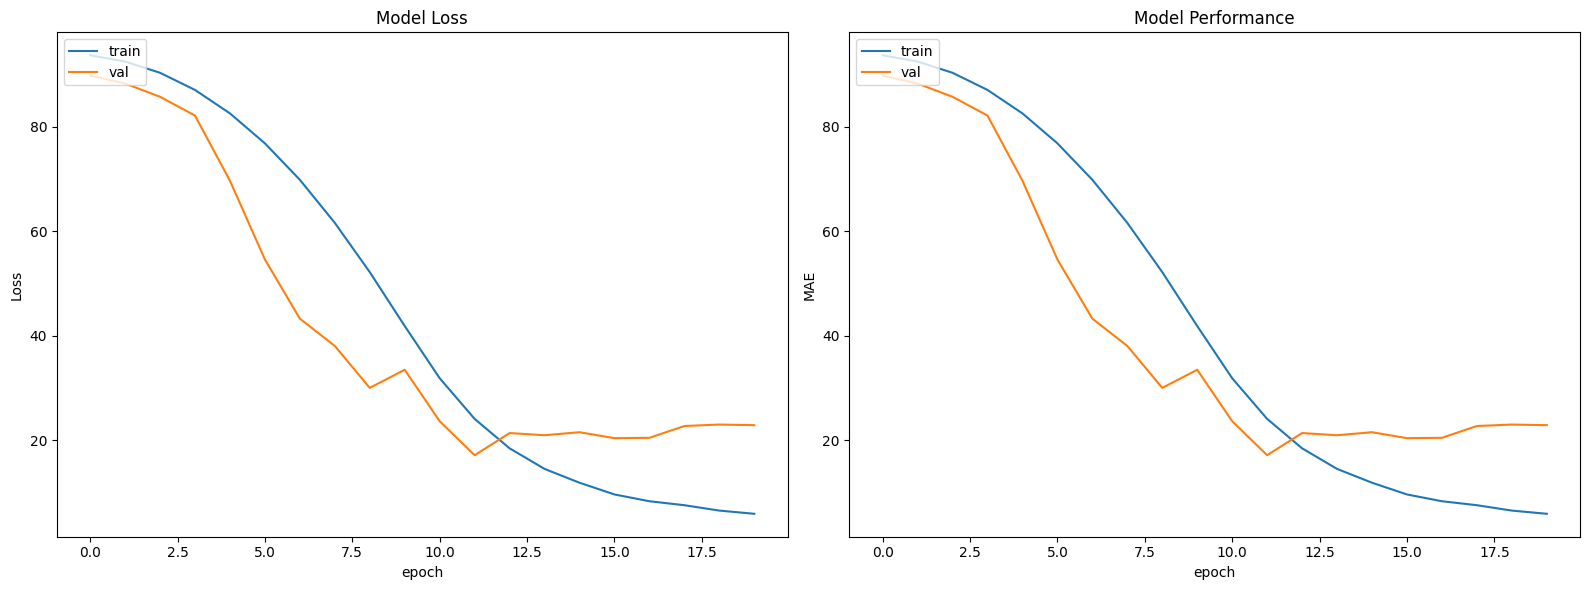

In [189]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(16, 6))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['mae'])
ax[1].plot(history.history['val_mae'])
ax[1].set_title('Model Performance')
ax[1].set_ylabel('MAE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

# Prediction

In [190]:
def transfer_negative(x):
    if x<0:
        return 0
    else:
        return x

# load best model
model.load_weights(checkpoint_filepath)
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][Feature_list].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_pred_test = model.predict(seq_array_test_last)

test_set = pd.DataFrame(y_pred_test, columns=['RUL'])
test_set['RUL'] = test_set['RUL'].apply(lambda x : transfer_negative(x)) 
test_set['RUL'] = test_set['RUL'].apply(lambda x : round(x,0)) 

test_set.index = test_set.index+1
test_set.to_csv('my_submission_kev.csv', index_label='id')

4/4 [==============================] - 2s 72ms/step


# 資源回收區

In [ ]:
# sequence_length = 30
# ratio = 0.2
# SIZE = seq_array.shape[0]
# window_size = seq_array.shape[1]
# feature_size = seq_array.shape[2]

# test = list(train_df.groupby(['id'])['cycle'].max()-sequence_length)
# test_output = []
# for i in range(len(test)):
#     if i==0:
#         test_output.append(test[i])
#     else:
#         test_output.append(test[i]+test_output[i-1])
        
# for id in range(97):

#     if id==0:
#         start_index = 0
#         end_index = test_output[id]
        
#         random_list = random.sample(range(start_index,end_index+1), end_index-start_index+1)
#         sample_size = int((end_index-start_index+1)*ratio)
        
#         for i_index,i in random_list:
#             if i_index==0:
#                 valid_array = seq_array[start_index:end_index]
#                 valid_label = label_array[start_index:end_index]                

#             elif i_index < sample_size:          
#                 valid_array = np.concatenate([valid_array,seq_array[start_index:end_index]])
#                 valid_label = np.concatenate([valid_label,label_array[start_index:end_index]])
                
#             elif i_index == sample_size:
#                 train_array = seq_array[start_index:end_index]                
#                 train_label = label_array[start_index:end_index] 
                
#             elif i_index > sample_size:
#                 train_array = np.concatenate([train_array,seq_array[start_index:end_index]])                
#                 train_label = np.concatenate([train_label,label_array[start_index:end_index]])
        
#     else:
#         start_index = test_output[id-1]
#         end_index = test_output[id]
        
#         random_list = random.sample(range(start_index,end_index+1), end_index-start_index+1)
#         sample_size = int((end_index-start_index+1)*ratio)
        
#         for i_index,i in random_list:             
#             if i_index < sample_size:          
#                 valid_array = np.concatenate([valid_array,seq_array[start_index:end_index]])
#                 valid_label = np.concatenate([valid_label,label_array[start_index:end_index]]) 
                
#             elif i_index >= sample_size:
#                 train_array = np.concatenate([train_array,seq_array[start_index:end_index]])                
#                 train_label = np.concatenate([train_label,label_array[start_index:end_index]])